# Jet tagging dataset

In [1]:
import h5py
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

Find the files and let's look at one of them

In [3]:
!ls

DataExploration.ipynb  qcd_img.h5    top_img.h5    wz_img.h5
Dataprep.ipynb	       qcd_small.h5  top_small.h5  wz_small.h5
qcd_const.h5	       top_const.h5  wz_const.h5


In [4]:
# filen='qcd'
filen='top'
# filen='wz'

In [5]:
qcd_df = pd.read_hdf(f"{filen}_small.h5")

The dataset has the four momentum of each jet and 7 useful variables to classify jets with, with definitions [here](https://arxiv.org/abs/1903.02942).

* tau1, tau2, and tau3 are the "probabilities" of a jet to be an N decay process (ie q, W->qq, top->bqq) based on subjets.
    * We often take ratios of these, e.g. tau32 is the ratio tau3/tau2
* d12 and d23 are "splitting scales"
* ECFX are "energy correlation factors"

In [23]:
qcd_df.head()

,pt,eta,phi,mass,tau1,tau2,tau3,d12,d23,ECF2,ECF3
0,573.512896,0.001286,-1.439587,169.559158,0.258243,0.087235,0.031253,145.331607,33.307623,0.150575,0.004606
1,453.906445,0.148402,-0.015148,145.272721,0.267623,0.102800,0.066175,129.132864,27.523841,0.171669,0.007646
2,478.369848,-0.952453,1.408995,119.665687,0.135924,0.085038,0.046444,43.297613,23.269530,0.101354,0.003606
3,478.048060,1.861573,1.775839,168.655579,0.281357,0.142024,0.059981,109.025442,42.558432,0.172889,0.008726
4,505.042383,0.352444,1.669010,174.539199,0.296595,0.157693,0.104523,148.969734,51.627565,0.199092,0.010626


Text(0.5, 0, '$\\tau_{32}$')

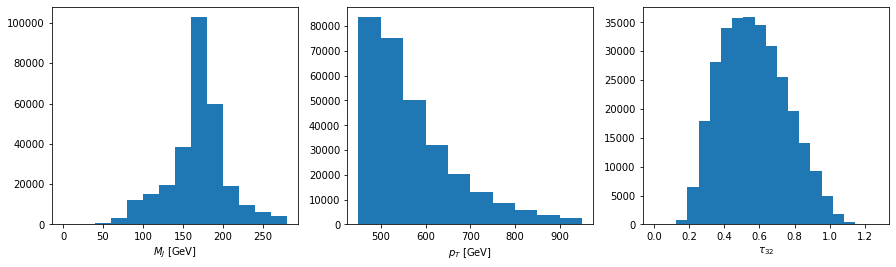

In [24]:
fig,axes = plt.subplots(1,3,figsize=(15,4))

axes[0].hist(np.clip(qcd_df.mass,0,300),bins=np.arange(0,300,20))
axes[0].set_xlabel(r'$M_J$ [GeV]')
axes[1].hist(np.clip(qcd_df.pt,450,1000),bins=np.arange(450,1000,50))
axes[1].set_xlabel(r'$p_T$ [GeV]')
axes[2].hist(qcd_df.tau3/qcd_df.tau2,bins=20)
axes[2].set_xlabel(r'$\tau_{32}$')

In [8]:
qcd_const = h5py.File(f"{filen}_const.h5")

In [9]:
qcd_const.keys()

<KeysViewHDF5 ['constituents']>

Constituents has the following shape: `(njet,nconst,4)`
with the 20 most important constituents per jet taken.

Each constituent has its four momentum in the form `(pT,eta,phi,m)`.

You can get the energy per constituent as `E=pT*cosh(eta)` and can centre all constituents using the jet eta and phi from the dataframe loaded before.

In [10]:
qc = qcd_const['constituents'][:10000]

In [11]:
qc_deta = qcd_df.eta[:10000,np.newaxis] - qc[:,:,1]
qc_dphi = qcd_df.phi[:10000,np.newaxis] - qc[:,:,2]

Phi is bounded to be between -pi and pi, so make sure when you take differences in delta you re-bound it!

In [12]:
np.min(qc_dphi),np.max(qc_dphi)

(-6.281009331048393, 6.277171248725887)

In [13]:
qc_dphi = np.where(qc_dphi < -np.pi,qc_dphi+2*np.pi,qc_dphi)
qc_dphi = np.where(qc_dphi > +np.pi,qc_dphi-2*np.pi,qc_dphi)

In [14]:
np.min(qc_dphi),np.max(qc_dphi)

(-2.854493781902538, 2.640294953530151)

In [15]:
qc_fracE = qc[:,:,0]*np.cosh(qc[:,:,1])/np.sum(qc[:,:,0]*np.cosh(qc[:,:,1]),axis=1)[::,np.newaxis]

In [16]:
import matplotlib

Let's look at the "image" form of one jet

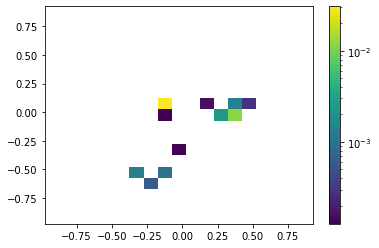

In [22]:
plt.hist2d(qc_deta[0].ravel(),qc_dphi[0].ravel(),weights=(qc_fracE[0].ravel()/len(qc_fracE[0])),bins=(np.arange(-0.975,0.975,0.1),np.arange(-0.975,0.975,0.1)),norm=matplotlib.colors.LogNorm())
plt.colorbar()

The "image" of the average jet

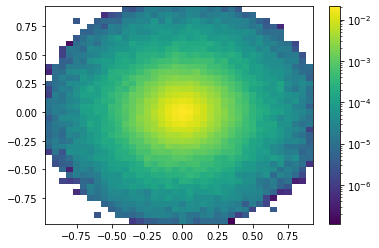

In [17]:
plt.hist2d(qc_deta.ravel(),qc_dphi.ravel(),weights=(qc_fracE.ravel()/len(qc_fracE)),bins=(np.arange(-0.975,0.975,0.05),np.arange(-0.975,0.975,0.05)),norm=matplotlib.colors.LogNorm())
plt.colorbar()

Use the substructure variables, the constituents, or even images to identify the origin of jets as either from top, W/Z or QCD.